In this notebook, we evaluate the AutoEncoder at different ADC ranges

In [61]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [62]:
wireplane = 'U'
np.random.seed(42)

def filter_signal_ADC(data, clean_data, adc_value, filter_by_max):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if filter_by_max:
            if max(clean_data[i]) < adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
        else:
            if max(clean_data[i]) > adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

Load testing set

In [63]:
x_test = np.load('../processed_data/x_test_' + wireplane + '.npy')
y_test = np.load('../processed_data/y_test_AE_' + wireplane + '.npy')
mean = np.load('../latest_models/mean_' + wireplane + '_nu.npy')
std = np.load('../latest_models/scale_' + wireplane + '_nu.npy')

In [64]:
x_test_scaled = (x_test-mean)/std

DEBUG START

In [65]:
y_test_scaled = []
for i in range(len(y_test)):
    if sum(y_test[i]) == 0:
        y_test_scaled.append(y_test[i])
    else:
        scaled = (y_test[i]-mean)/std
        y_test_scaled.append(scaled)
y_test_scaled = np.array(y_test_scaled)


DEBUG END

Load trained model

In [66]:
autoencoder = load_model('../latest_models/model_AE_' + wireplane + 'plane_nu.h5')

In [67]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

25/25 [==============================] - 0s 12ms/step - loss: 0.0611


0.06110098212957382

### let's see what the MSE is at the region where signal exists

In [68]:
%%time
predictions = autoencoder.predict(x_test_scaled, batch_size=4096)
predictions = predictions.reshape(predictions.shape[0], predictions.shape[1])

25/25 [==============================] - 0s 5ms/step
Wall time: 346 ms


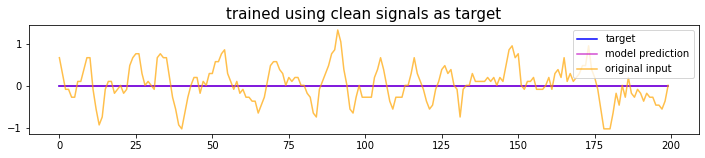

0.00948425568640232
1.8626451e-09


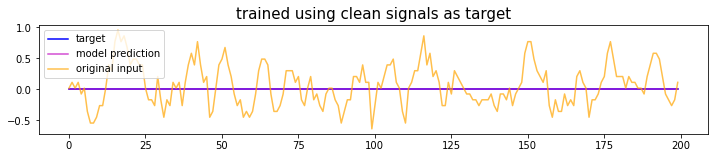

0.00948425568640232
1.8626451e-09


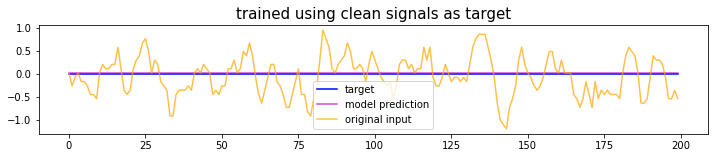

0.00948425568640232
1.8626451e-09


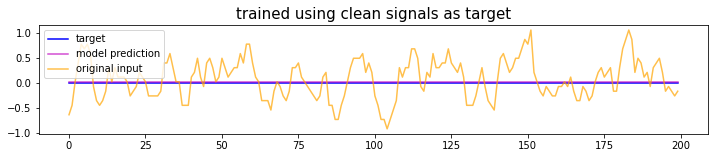

0.00948425568640232
1.8626451e-09


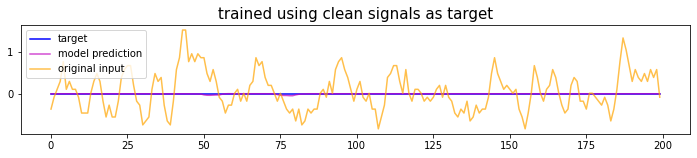

0.006954544787295163
0.008723733


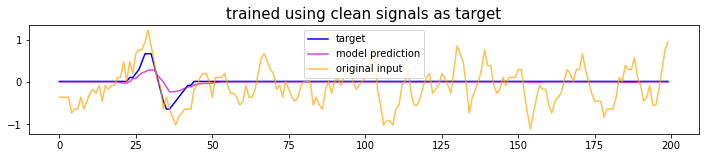

0.008149078225251287
0.060786124


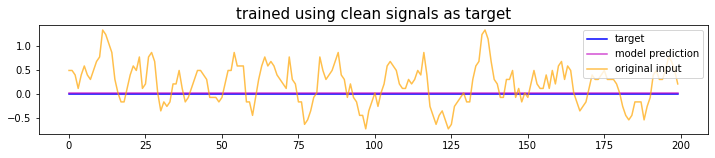

0.00948425568640232
1.8626451e-09


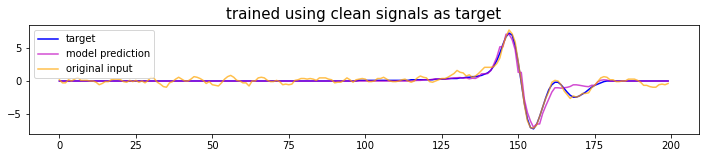

0.005069946534931659
1.5865037


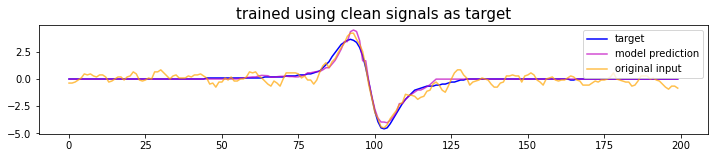

0.01568509519100189
1.1298512


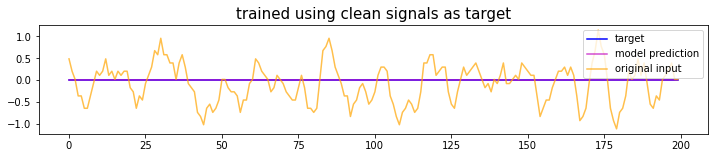

0.009284447717946023
0.00092461356


In [69]:
for idx in range(10):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(y_test_scaled[idx],color='blue', label='target')
    ax1.plot(predictions[idx],color='m',alpha=0.7, label='model prediction')
    ax1.plot(x_test_scaled[idx], color='orange',alpha=0.7, label = 'original input')
    ax1.set_title("trained using clean signals as target", fontsize=15)
    ax1.legend()
    

    plt.show()
    print(sum(predictions[idx])/len(predictions[idx]))
    print(predictions[idx].std())

Checkpoint reached

In [70]:
# calculate MSE for the entire range
mse = np.mean((y_test_scaled - predictions)**2)
print("MSE for entire range:", mse)

MSE for entire range: 0.06110097817454312


In [71]:
def find_baseline(wave):
    baseL = -1000  # for pure noise signal
    if sum(wave) != 0:
        # Find the unique values in the array
        unique_values = np.unique(wave)
        # Create a new array that contains the number of occurrences of each unique value
        counts = np.array([(wave == value).sum() for value in unique_values])
        # Find the index of the largest count, which corresponds to the most common value
        most_common = np.argmax(counts)
        baseL = unique_values[most_common]
    return baseL


In [72]:
# there are cases where the ADC values goes up or down at the edge. We cehck them here
def check_end(array, ranges, baseline):
    end = 200
    res = []
    if abs(array[199]) > abs(find_baseline(array)) and ranges[len(ranges)-1] != end:
        start = end-1
        while start > 0 and array[start] > abs(find_baseline(array)):
            start -= 1
            res = [start, end]
    return res

In [73]:
def combine_overlapping_ranges(ranges):
    # sort the original list in ascending order according to the first element in each sublist
    ranges = sorted(ranges, key=lambda x: x[0])

    # initialize the result list
    result = []

    # iterate over the sorted list and combine overlapping sublists
    for range in ranges:
        if result and range[0] <= result[-1][1]:
            # combine the current sublist with the previous one
            result[-1] = [min(range[0], result[-1][0]), max(range[1], result[-1][1])]
        else:
            # no overlap, so simply append the current sublist to the result
            result.append(range)

    return result

In [74]:
# takes single wave (array), and baseline (the value at which the wave is flat) and returns
# a list of ranges where there are signals waveforms
from scipy.signal import find_peaks
def find_peak_range(array, baseline):
    array = abs(array)
    # find the peaks
    peaks, _ = find_peaks(array)
    peak_ranges = []
    start_spc = 0
    end_spc = 0

    if abs(array[0]) > baseline:
        end_spc = 0
        while end_spc < 200 and ((array[end_spc] > baseline) or (array[end_spc] < baseline)):
            end_spc += 1

    for peak in peaks:
        if peak == end_spc:
            end = peak
            while end < 200 and array[end] > abs(baseline):
                end += 1
            if [start_spc, end] not in peak_ranges:
                peak_ranges.append([start_spc, end])

        else:
            start = peak
            while start > 0 and array[start] > abs(baseline):
                start -= 1
        
            end = peak
            while end < 200 and array[end] > abs(baseline):
                end += 1
            if [start, end] not in peak_ranges:
                peak_ranges.append([start, end])

    end_case = check_end(array, peak_ranges, baseline)
    if len(end_case) > 0:
        peak_ranges.append(end_case)
    peak_ranges = combine_overlapping_ranges(peak_ranges)

    return peak_ranges

Note that there are waves with signals in multiple locations. For these we take the average MSE for all locations

In [75]:
multi_range_idxs = []
for i in range(len(y_test_scaled)):
#for i in range(5):
    bl = find_baseline(y_test_scaled[i])
    if bl != -1000:
        ranges = find_peak_range(y_test_scaled[i], bl)
        if len(ranges) > 1:
            multi_range_idxs.append(i)
print(len(multi_range_idxs))

11048


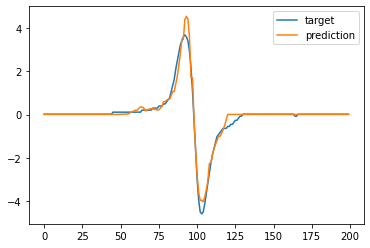

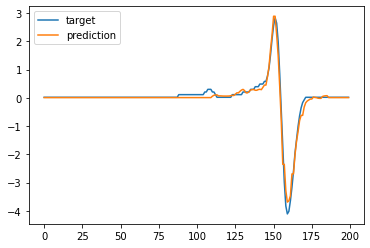

In [76]:
curr = 0
end = 2
for idx in multi_range_idxs:
    curr += 1
    if curr > end:
        continue
    plt.plot(y_test_scaled[idx],label = "target")
    plt.plot(predictions[idx], label = "prediction")
    plt.legend()
    plt.show()

In [77]:
def calculate_single_mse_helper(expected_wave, pred_wave):
    single_mse = np.mean((expected_wave-pred_wave)**2)
    return single_mse

In [78]:
def calculate_single_mse(expected, prediction):
    mse = 0
    if sum(expected) == 0:
        mse = calculate_single_mse_helper(expected, expected)
    else:
        baseL = find_baseline(expected)
        if baseL == -1000:
            print("bug! - this should not be happening since bl=-1000 means if above should have taken effect")
        ranges = find_peak_range(expected, baseL)
        
        expected_waves = []
        pred_waves = []
        mses = []

        for range_ in ranges:
            expected_wave = expected[range_[0]:range_[1]]
            pred_wave = prediction[range_[0]:range_[1]]
            mses.append(calculate_single_mse_helper(expected_wave, pred_wave))
        mse = sum(mses)
    return mse 

In [79]:
print(y_test_scaled.shape)

(100000, 200)


In [80]:
MSES = []
nan_idxs = []
for idx in range(len(y_test_scaled)):
    ms_e = calculate_single_mse(y_test_scaled[idx], predictions[idx])

    if np.isnan(ms_e):
        nan_idxs.append(idx)
    else:
        MSES.append(ms_e)

c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [81]:
print(len(MSES), len(nan_idxs), y_test_scaled.shape[0]-len(MSES))

99976 24 24


In [83]:
nan_idxs

[1548,
 1763,
 1829,
 3277,
 3355,
 11702,
 12675,
 19601,
 28986,
 30615,
 36774,
 40899,
 43765,
 43939,
 47765,
 52459,
 56912,
 75240,
 75318,
 82098,
 83610,
 91871,
 96106,
 99896]

When calculating MSES, there were 24 waveforms that yielded NANs. The indices for these waves have been saved. And for future reference will be ignored

1548


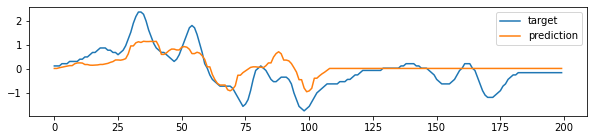

1763


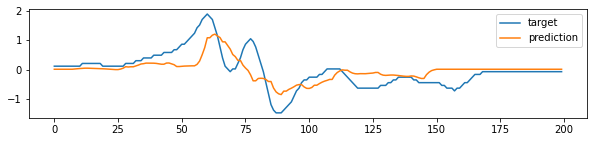

In [86]:
curr = 0
stop = 2
for i in nan_idxs:
    curr += 1
    if curr > stop:
        continue 
    print(i)
    fig = plt.figure(figsize=(10, 2))
    plt.plot(y_test_scaled[i],label = "target")
    plt.plot(predictions[i], label = "prediction")
    plt.legend()
    plt.show()

### Checkpoint reached!

Next: at the moment MSEs are being calculating for just one range. However there are waves with multiple ranges. We need to take this into account

In [88]:
print(calculate_single_mse(x_test_scaled[0], predictions[15]))

nan


c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Checkpoint reached!

NOTE: MSE IS CALCULATED FOR ONE WAVE. NEED TO LOOP TO GET ALL WAVES

In [120]:
# adc_max = 0 means no max cut is applied
def eval_cut_(x_test_, y_test_, adc_min, adc_max):
    print(x_test_.shape, y_test_.shape)

    test_, clean_ =  filter_signal_ADC(x_test_, y_test_, adc_min, False)
    print(test_.shape, clean_.shape)
    if adc_max != 0:
        test_, clean_ =  filter_signal_ADC(test_, clean_, adc_max, True)
    print(test_.shape, clean_.shape)


    x_test_scaled_ = (x_test_-mean)/std
    clean_scaled_ = clean_
    
    y_test_scaled_ = []
    for i in range(len(y_test_)):
        if sum(y_test_[i]) == 0:
            y_test_scaled_.append(y_test_[i])
        else:
            scaled_ = (y_test_[i]-mean)/std
            y_test_scaled_.append(scaled_)
    y_test_scaled_ = np.array(y_test_scaled_)


    all_pred = autoencoder.predict(x_test_scaled, batch_size=4096)
    all_pred = all_pred.reshape(all_pred.shape[0], all_pred.shape[1])

    MSES_ = []
    nan_idxs_ = []
    for idx in range(len(y_test_scaled)):
        mse_ = calculate_single_mse(y_test_scaled[idx], all_pred[idx])

        if not np.isnan(mse_):
            MSES.append(mse_)
        else:
            nan_idxs_.append(idx)
    return MSES, nan_idxs_

In [121]:
mse_3_15 = []
nans_3_15 = []
for i in range(3, 16):
    eval_cut_(x_test, y_test, i, 0)
    mses_, nans = eval_cut_(x_test, y_test, i, 0)
    mse_3_15.append([mses_])
    nans_3_15.append([nans])


(100000, 200) (100000, 200)
(100000, 200) (100000, 200)
(100000, 200) (100000, 200)
25/25 [==============================] - 0s 12ms/step


c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(100000, 200) (100000, 200)
(100000, 200) (100000, 200)
(100000, 200) (100000, 200)
25/25 [==============================] - 0s 10ms/step
(100000, 200) (100000, 200)
(96875, 200) (96875, 200)
(96875, 200) (96875, 200)
25/25 [==============================] - 0s 10ms/step
(100000, 200) (100000, 200)
(96875, 200) (96875, 200)
(96875, 200) (96875, 200)
25/25 [==============================] - 0s 16ms/step
(100000, 200) (100000, 200)
(94438, 200) (94438, 200)
(94438, 200) (94438, 200)
25/25 [==============================] - 0s 13ms/step
(100000, 200) (100000, 200)
(94438, 200) (94438, 200)
(94438, 200) (94438, 200)
25/25 [==============================] - 0s 8ms/step
(100000, 200) (100000, 200)
(92520, 200) (92520, 200)
(92520, 200) (92520, 200)
25/25 [==============================] - 0s 11ms/step
(100000, 200) (100000, 200)
(92520, 200) (92520, 200)
(92520, 200) (92520, 200)
25/25 [==============================] - 0s 11ms/step
(100000, 200) (100000, 200)
(90830, 200) (90830, 200)
(9083

In [117]:
print(len(mse_3_15), len(nans_3_15))

13 13


In [118]:
mse_3_15

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.06919157527527206,
  0.0,
  0.4079431678296702,
  0.10714980215404141,
  0.0,
  0.23420106314502684,
  0.08437424805387914,
  0.0,
  0.0,
  0.0,
  0.10037199064320618,
  0.17525535780030763,
  0.0,
  0.0,
  0.08868142153395184,
  0.07975488806363873,
  0.0640480225667451,
  0.2326559820527012,
  0.20424078695522638,
  0.6892616768384576,
  0.0,
  0.05925073053392689,
  0.36293837229255654,
  2.863624898537286,
  0.5403039337516207,
  0.0,
  0.16948971982063893,
  0.19231476874925216,
  0.0,
  0.22762618594148595,
  0.24198988581148315,
  0.22016012222373768,
  0.0,
  0.09035125940532407,
  0.0,
  0.0,
  0.6301364206293969,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.1885776405123612,
  0.14976328874424655,
  0.22775485505296503,
  0.0,
  0.0,
  0.0,
  0.09635138001263774,
  0.47761904187190446,
  0.3012020051884541,
  0.07569576422249538,
  0.0,
  0.009987989828170264,
  0.6595162645457332,
  0.0,
  0.2268999653714109,
  0.16128836345696004,
  0.0,
  0